In [44]:

import random
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm  
import seaborn as sns
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Flatten, Permute, LSTM, Conv1D, Dropout, Bidirectional, Multiply, \
    Concatenate, Multiply, Lambda, RepeatVector, Activation
from tensorflow.keras.models import Model, Sequential
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = 'songti sc'

In [48]:
data1 = pd.read_csv("./speed.csv")
data1.index = range(len(data1))
data1.head()

,时间,车流量,温度,湿度,气压,道路拥堵指数,车速(m/s)
0,2023/3/1 0:00,3119,6.635445,41.991183,101.304484,0.618239,22
1,2023/3/1 0:15,1599,24.484669,54.049135,101.692347,0.390966,21
2,2023/3/1 0:30,1669,23.021680,58.524927,101.720204,0.453731,21
3,2023/3/1 0:45,2653,13.656662,43.941204,101.201497,0.438441,22
4,2023/3/1 1:00,2826,11.674758,36.631670,100.977894,0.448393,23


In [3]:
import random
random.uniform(-1,1)

0.9191670780704275

In [4]:
data = pd.read_csv("./车速.csv")
data.index = range(len(data))
data.head()

,车流量,温度,湿度,气压,道路拥堵指数,车速(m/s)
0,3960.832410,5.992408,43.717045,111.602721,1.014586,22
1,3786.932510,4.757902,28.855593,90.830960,0.562140,21
2,3836.199349,4.387279,31.634415,91.625547,0.725007,21
3,3906.367581,5.349613,45.960635,105.019298,0.931661,22
4,3908.317866,7.228756,37.481801,104.804301,0.740060,23


## 数据分析

In [5]:
# 数据维度
df = data.copy()
print(df.shape)

(7201, 6)


In [6]:
# 数据字段类型
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7201 entries, 0 to 7200
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   车流量      7201 non-null   float64
 1   温度       7201 non-null   float64
 2   湿度       7201 non-null   float64
 3   气压       7201 non-null   float64
 4   道路拥堵指数   7201 non-null   float64
 5   车速(m/s)  7201 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 337.7 KB
None


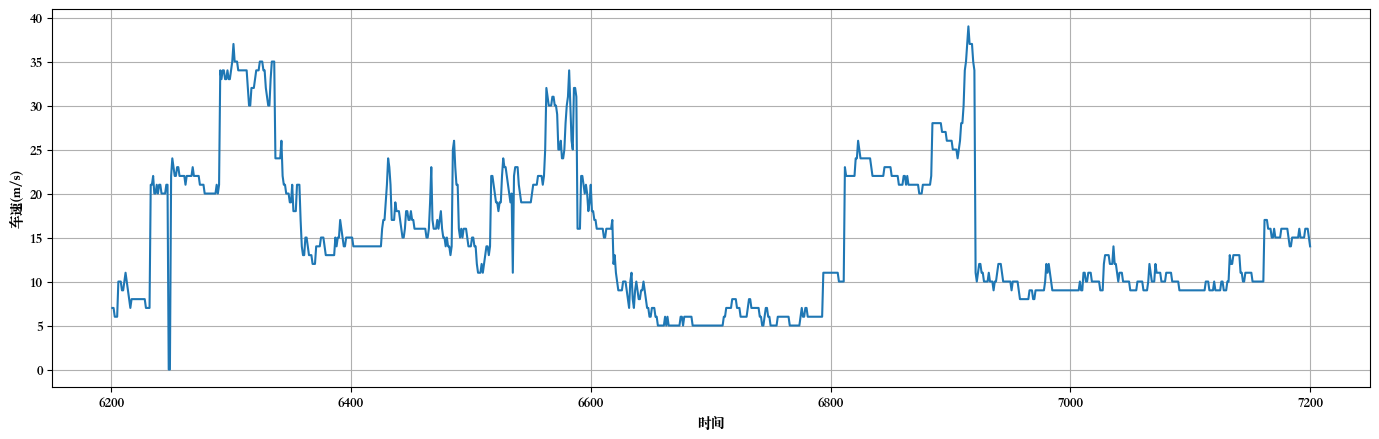

In [7]:
# 车速的时间序列走势
plt.figure(figsize=(17,5), dpi=100)
plt.plot(df.index[-1000:], df['车速(m/s)'][-1000:])
plt.grid()
plt.xlabel("时间")
plt.ylabel("车速(m/s)")
plt.show()

<Figure size 432x288 with 0 Axes>

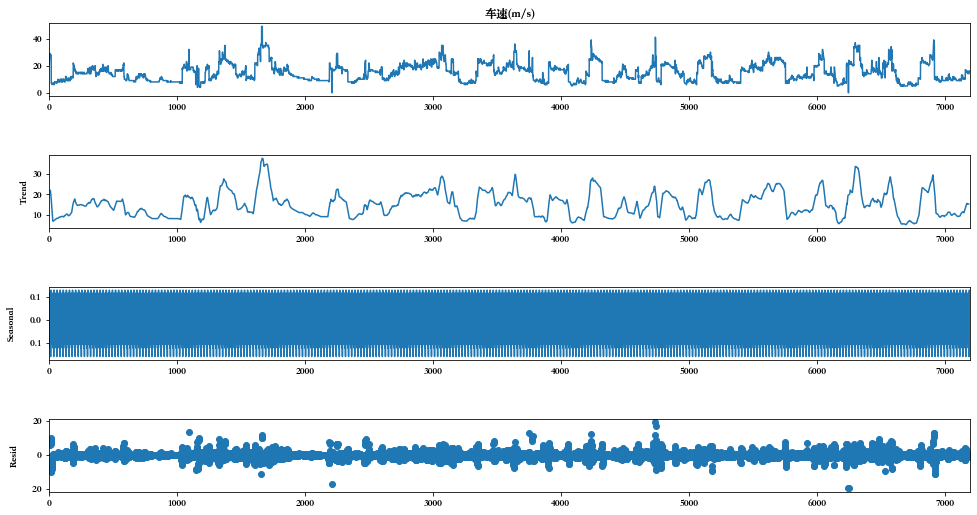

In [8]:
# 可见数据存在一定的时间周期
# 进一步的分析时间的周期性、季节趋势等
decomposition = seasonal_decompose(df['车速(m/s)'], period=24) 
# 
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)
plt.show()

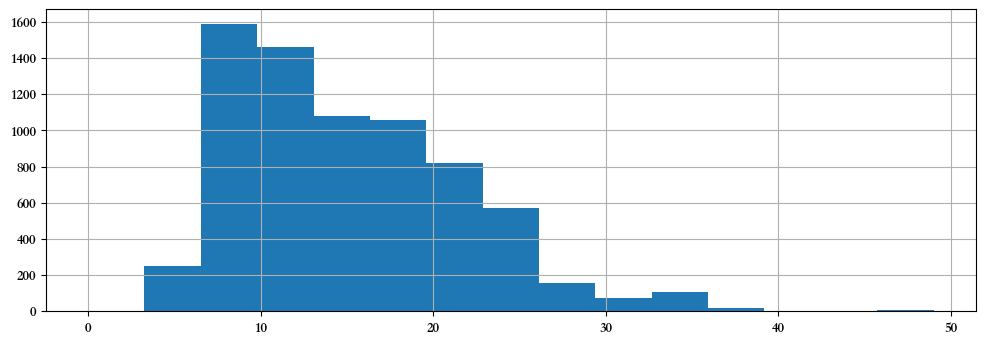

In [9]:
#车速(m/s)的直方图分布\
plt.figure(figsize=(12,4), dpi=100)
plt.hist(df['车速(m/s)'], bins=15)
plt.grid()
plt.show() # 分布比较均衡,大多30和40左右

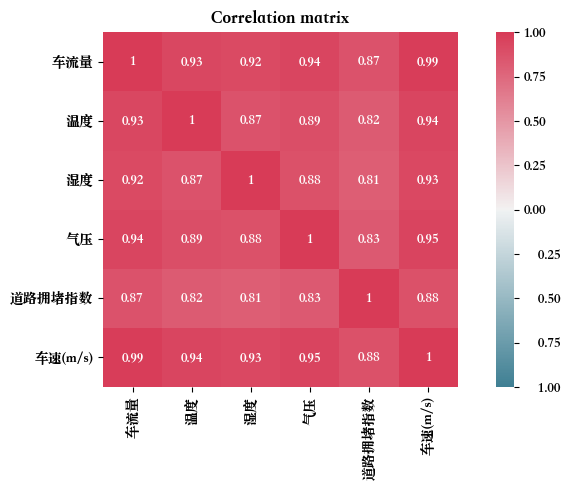

In [10]:
fig, ax=plt.subplots(figsize=(8,5), dpi=100)
cmap = sns.diverging_palette(220, 6, as_cmap=True)
sns.heatmap(df.corr(), vmax=1, vmin=-1, center=0, square=True, ax=ax, cmap=cmap, annot=True)
ax.set_title('Correlation matrix', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

In [11]:
# 和各个变量之间的相关性高

## 数据预处理

In [12]:
# 数据归一化
# 时间序列对数据量纲是十分敏感的，所以必须进行数据归一化
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# dataset = df['车速(m/s)'].values
dataset = df.values
dataset = dataset.astype('float32')
# dataset = dataset.reshape(-1, 1)
scaler = MinMaxScaler()
sc_model_X = scaler.fit(dataset[:,:-1])
dataset_X= sc_model_X.transform(dataset[:,:-1])
dataset_X.shape

(7201, 5)

In [13]:

scaler = MinMaxScaler()
sc_model_y = scaler.fit(dataset[:,-1].reshape(-1,1))
dataset_y= sc_model_y.transform(dataset[:,-1].reshape(-1,1))
dataset_y.shape

(7201, 1)

In [14]:
# 训练和测试的划分
# 7:3的比例分为训练集和测试集
train_size = int(len(dataset) * 0.7)  ##前70%作为训练，30%作为测试
test_size = len(dataset) - train_size
train_X, test_X = dataset_X[0:train_size,:], dataset_X[train_size:len(dataset_X),:]
train_Y, test_Y = dataset_y[0:train_size], dataset_y[train_size:len(dataset_y)]

print(len(train_X), len(test_X))

5040 2161


## LSTM模型

In [15]:
def creat_dataset(data_X,data_Y, lagTerm=1):
    # 创建数据集以供LSTM使用，转换为LSTM所需要的数据格式
    # lagTerm: 滑动窗口大小，认为前lagTerm条数据将会影响lagTerm+1的数据
    dataX, dataY = [],[]
    for i in range(len(data_X) - lagTerm):
        cache = data_X[i:(i+lagTerm),:]
        dataX.append(cache)
        dataY.append(data_Y[i+lagTerm])
    return np.array(dataX), np.array(dataY)
look_back = 10
trainX,trainY = creat_dataset(train_X,train_Y, look_back)
testX, testY = creat_dataset(test_X,test_Y, look_back)

In [16]:
#训练和测试的数据维度转换 [samples, time_steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(5030, 10, 5) (5030, 1)
(2151, 10, 5) (2151, 1)


采用mse作为损失函数，采用Adam梯度优化算法，学习率为0.001。在模型训练过程中，我们设置了100个epoch，并使用早停法（Early Stopping）避免过拟合。模型的训练过程中采用了批量训练（Batch Training）

In [17]:
from tensorflow.keras.optimizers import Adam
def lstm_model(numEpoch,batchSize,X,y,callBack):
    model = Sequential()
    model.add(LSTM(
        120,
        input_shape=(X.shape[1], X.shape[2]),
        return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(
        128,
        return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=64, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation("relu"))
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mae', metrics=['mse'])
    history = model.fit(X,y,epochs = numEpoch, batch_size=32, verbose=1, validation_split=0.25, callbacks=callBack)
    return model,history

In [18]:
import tensorflow as tf
# Early stop callback function.

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
# 保存模型
model_save = tf.keras.callbacks.ModelCheckpoint(filepath="lstm_15min.h5", save_weights_only=False, monitor='val_loss',
                                 save_best_only=True)
lstm, lstm_history = lstm_model(100, 32, trainX, trainY, [model_save])

2023-12-21 22:42:17.770824: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-12-21 22:42:17.774001: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 22:42:21.054841: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/100
118/118 [==============================] - 20s 87ms/step - loss: 0.2078 - mse: 0.4937 - val_loss: 0.0499 - val_mse: 0.0051
Epoch 2/100
118/118 [==============================] - 6s 49ms/step - loss: 0.0458 - mse: 0.0047 - val_loss: 0.0336 - val_mse: 0.0029
Epoch 3/100
118/118 [==============================] - 6s 48ms/step - loss: 0.0355 - mse: 0.0031 - val_loss: 0.0306 - val_mse: 0.0022
Epoch 4/100
118/118 [==============================] - 5s 46ms/step - loss: 0.0346 - mse: 0.0027 - val_loss: 0.0253 - val_mse: 0.0017
Epoch 5/100
118/118 [==============================] - 5s 46ms/step - loss: 0.0316 - mse: 0.0023 - val_loss: 0.0337 - val_mse: 0.0021
Epoch 6/100
118/118 [==============================] - 5s 45ms/step - loss: 0.0316 - mse: 0.0024 - val_loss: 0.0302 - val_mse: 0.0019
Epoch 7/100
118/118 [==============================] - 5s 44ms/step - loss: 0.0295 - mse: 0.0020 - val_loss: 0.0253 - val_mse: 0.0014
Epoch 8/100
118/118 [==============================] - 6s 47m

Epoch 62/100
118/118 [==============================] - 3s 27ms/step - loss: 0.0265 - mse: 0.0018 - val_loss: 0.0176 - val_mse: 0.0011
Epoch 63/100
118/118 [==============================] - 3s 25ms/step - loss: 0.0261 - mse: 0.0017 - val_loss: 0.0236 - val_mse: 0.0014
Epoch 64/100
118/118 [==============================] - 3s 27ms/step - loss: 0.0271 - mse: 0.0018 - val_loss: 0.0200 - val_mse: 0.0012
Epoch 65/100
118/118 [==============================] - 3s 26ms/step - loss: 0.0263 - mse: 0.0017 - val_loss: 0.0234 - val_mse: 0.0013
Epoch 66/100
118/118 [==============================] - 3s 28ms/step - loss: 0.0268 - mse: 0.0017 - val_loss: 0.0172 - val_mse: 0.0010
Epoch 67/100
118/118 [==============================] - 3s 28ms/step - loss: 0.0266 - mse: 0.0019 - val_loss: 0.0203 - val_mse: 0.0012
Epoch 68/100
118/118 [==============================] - 3s 26ms/step - loss: 0.0254 - mse: 0.0016 - val_loss: 0.0173 - val_mse: 0.0010
Epoch 69/100
118/118 [==============================] -

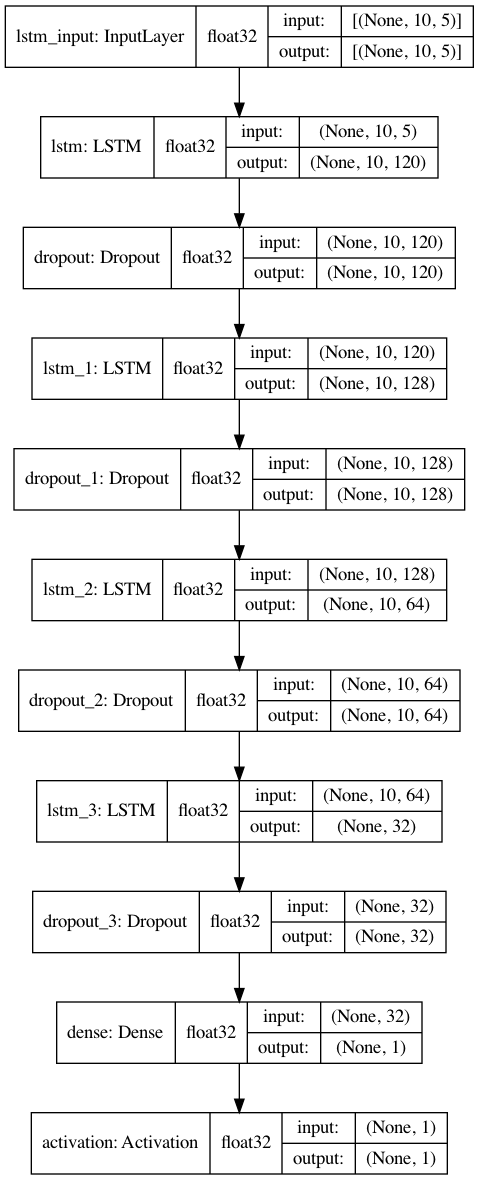

In [19]:
plot_model(lstm, "lstm.png", show_dtype=True,
          show_layer_names=True, show_shapes = True)

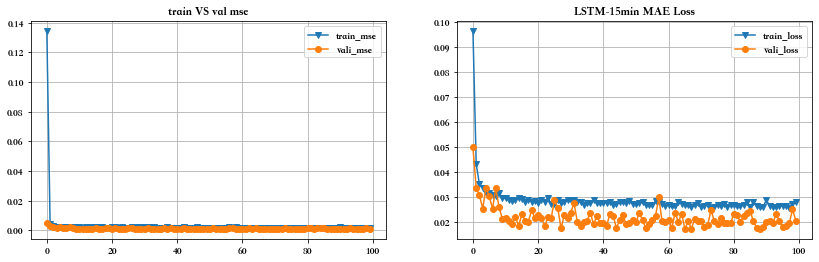

In [20]:
train_loss=lstm_history.history['loss']
vali_loss=lstm_history.history['val_loss']
train_acc = lstm_history.history['mse']
vali_acc = lstm_history.history['val_mse']
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(range(len(train_acc)),train_acc,marker='v',label='train_mse')
plt.plot(range(len(train_acc)),vali_acc,marker='o',label='vali_mse')
plt.legend()
plt.title("LSTM-15min MSE")
plt.grid()
plt.title("train VS val mse")
plt.subplot(1,2,2)
plt.plot(range(len(train_loss)),train_loss,marker='v',label='train_loss')
plt.plot(range(len(train_loss)),vali_loss,marker='o',label='vali_loss')
plt.legend()
plt.title("train VS val loss")
plt.grid()
plt.title("LSTM-15min MAE Loss")
plt.show()

In [41]:
# LSTM模型在测试上的效果--MSE和MAE以及MAPE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import load_model
lstm_best = load_model("lstm_15min.h5")
lstm_pred = lstm_best.predict(testX)
inverse_lstm_pred = sc_model_y.inverse_transform(lstm_pred.reshape(-1,1))
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
inverse_test = sc_model_y.inverse_transform(testY.reshape(-1,1))
lstm_rmse = np.sqrt(mean_squared_error(inverse_test, inverse_lstm_pred))
lstm_mae = mean_absolute_error(inverse_test, inverse_lstm_pred)

# 均方根误差、平均绝对误差
print("LSTM 15min MAE:", lstm_mae)
print("LSTM 15min RMSE:", lstm_rmse)

LSTM 15min MAE: 0.9435141
LSTM 15min RMSE: 1.7825676


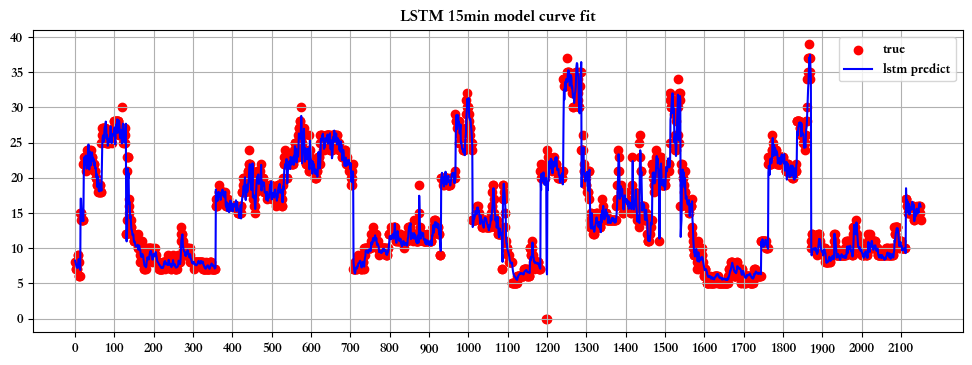

In [43]:
indexs = range(len(df.index[-testX.shape[0]:]))
# 拟合情况
plt.figure(figsize = (12,4), dpi=100)
plt.scatter(indexs, inverse_test, marker='o', label='true', c='red')
plt.plot(indexs, inverse_lstm_pred, c='blue', label='lstm predict')
plt.legend()
plt.title("LSTM 15min model curve fit")
plt.xticks(np.arange(0, len(df.index[-testX.shape[0]:]), 100))
plt.grid()
plt.show() # 可见拟合得很好

## ARIMA

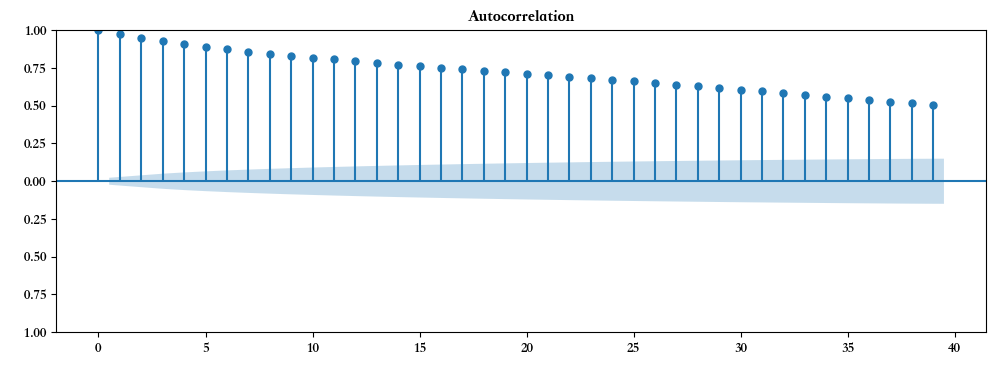

In [23]:
series = np.array(df['车速(m/s)'].values)
from statsmodels.graphics.tsaplots import plot_acf
fig = plt.figure(figsize=(12,4), dpi=100)
ax1=fig.add_subplot(111)
plot_acf(series,ax=ax1).show()###自相关图检验平稳性

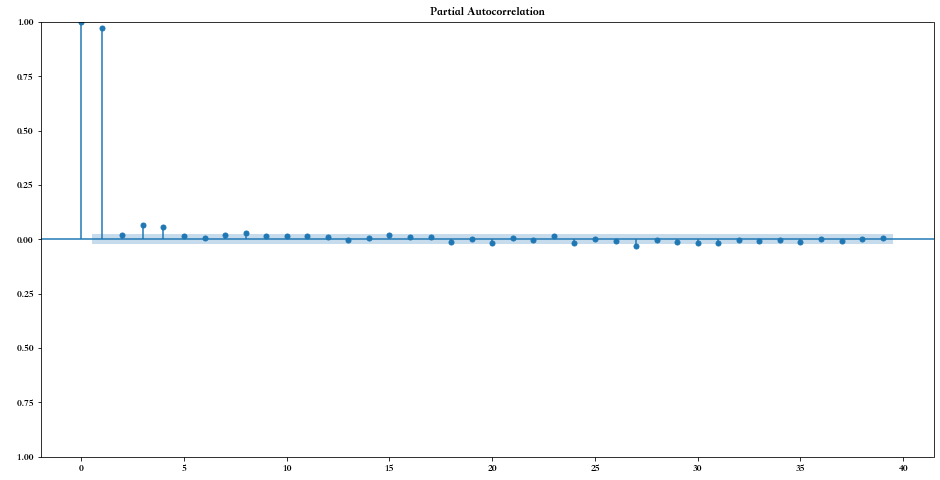

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf###偏自相关图
fig = plt.figure(figsize=(16,8))
ax2=fig.add_subplot(111)
plot_pacf(series,ax=ax2).show()

In [25]:
# 平稳性检测
from statsmodels.tsa.stattools import adfuller as ADF

print('原始序列的ADF检验结果为:',ADF(series)) 

原始序列的ADF检验结果为: (-7.363833723010498, 9.348399679062679e-11, 10, 7190, {'1%': -3.4312598242236394, '5%': -2.861942070882888, '10%': -2.5669840181754524}, 26038.59623096793)


In [26]:
# 本身平稳 不用做差分， d=0

In [27]:
# 设置，q阶范围
# product p,q的所有组合
# 设置最好的aic为无穷大
# 对范围内的p,q阶进行模型训练，得到最优模型
import statsmodels.api as sm
from itertools import product
import warnings
warnings.filterwarnings('ignore')
ps = range(0,5)
qs = range(0,5)
parameters = product(ps, qs)
parameters_list = list(parameters)
best_aic = float('inf')
results = []
for param in parameters_list:
    try:
        model = sm.tsa.arima.ARIMA(series, order=(param[0],0, param[1])).fit()
    except ValueError:
        print("参数错误：", param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = model.aic
        best_param = param
    results.append([param, model.aic])
results_table = pd.DataFrame(results)
results_table.columns = ['parameters', 'aic']
print("最优模型", best_model.summary())

最优模型                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7201
Model:                 ARIMA(4, 0, 3)   Log Likelihood              -13161.421
Date:                Thu, 21 Dec 2023   AIC                          26340.843
Time:                        22:50:18   BIC                          26402.781
Sample:                             0   HQIC                         26362.155
                               - 7201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.3844      0.998     15.410      0.000      13.428      17.341
ar.L1          1.7001      0.167     10.173      0.000       1.373       2.028
ar.L2         -1.3320      0.302     -4.414    

In [28]:
# 最佳模型ARIMA(3，0,3)
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7201
Model:                 ARIMA(4, 0, 3)   Log Likelihood              -13161.421
Date:                Thu, 21 Dec 2023   AIC                          26340.843
Time:                        22:50:18   BIC                          26402.781
Sample:                             0   HQIC                         26362.155
                               - 7201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.3844      0.998     15.410      0.000      13.428      17.341
ar.L1          1.7001      0.167     10.173      0.000       1.373       2.028
ar.L2         -1.3320      0.302     -4.414      0.0

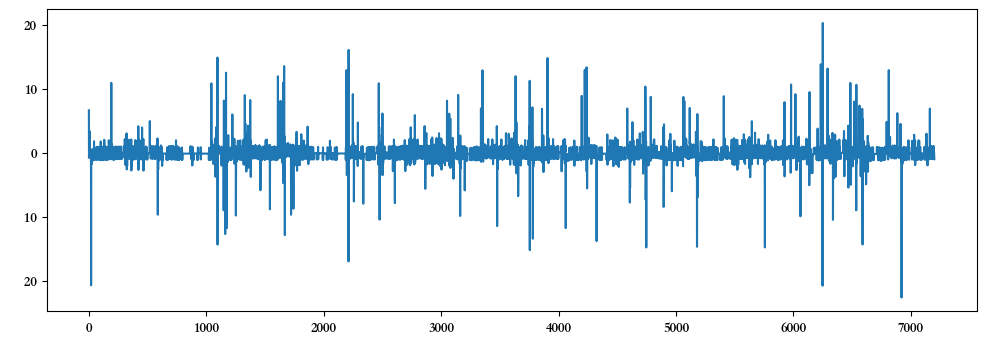

In [29]:
resid=best_model.resid  #残差
plt.figure(figsize=(12,4), dpi=100)
plt.plot(resid)
plt.show()

In [30]:
from scipy import stats 
print(stats.normaltest(resid))#检验序列残差是否为正态分布    pvalue<  0.05  拒绝原假设 认为残差符合正太分布

NormaltestResult(statistic=2691.63816134868, pvalue=0.0)


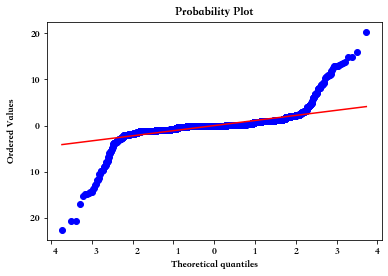

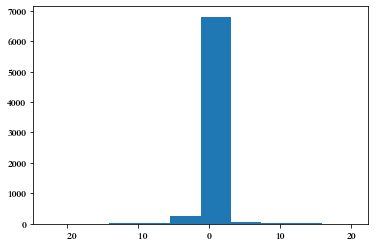

In [31]:
# p<0.05,接受备择假设，认为残差具有正态性
stats.probplot(resid, dist="norm", plot=plt)
plt.show()
plt.hist(resid,bins=10)
plt.show()

In [32]:
! pip install statsmodels

Looking in indexes: https://mirrors.aliyun.com/pypi/simple


In [33]:
# qq图散点基本在直线上，同时直方图也呈现正态性。
from statsmodels.stats.stattools import durbin_watson
print("DW检验:", durbin_watson(best_model.resid))  ##DW检验：靠近2——正常；靠近0——正自相关；靠近4——负自相关

DW检验: 1.9973089496683567


In [34]:
# DW值靠近2，说明序列不具有相关性
# 打印模型训练和测试， 计算损失
from statsmodels.tsa.arima_model import ARIMA
from itertools import product
import tqdm
size=int(0.7*len(series)) # 70%训练，30%测试
train, test_arima = series[:size], series[size:len(series)]
history=[k for k in train]
predictions = list()
indexs1 = range(len(df.index[size:len(series)]))

In [35]:
c=0
for t in range(len(test_arima)-1):
    c+=1
    try:
        model = sm.tsa.arima.ARIMA(history, order=(4,0,3))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = int(output[0])#预测
        predictions.append(yhat)
        obs = test_arima[t]##真实值
        history.append(obs)
        print(f"all {len(test_arima)} No.{c} {indexs1[c-1]}==> predicted=%d, expected=%d"% (yhat, obs))
    except:
        yhat = test_arima[t]
        predictions.append(yhat)
        obs = test_arima[t]
        history.append(obs)
        print(f"all {len(test_arima)} No.{c} {indexs1[c-1]}==> predicted=%d, expected=%d"% (yhat, obs))
        

all 2161 No.1 0==> predicted=8, expected=9
all 2161 No.2 1==> predicted=9, expected=9
all 2161 No.3 2==> predicted=9, expected=9
all 2161 No.4 3==> predicted=9, expected=9
all 2161 No.5 4==> predicted=9, expected=10
all 2161 No.6 5==> predicted=10, expected=10
all 2161 No.7 6==> predicted=9, expected=9
all 2161 No.8 7==> predicted=9, expected=9
all 2161 No.9 8==> predicted=9, expected=8
all 2161 No.10 9==> predicted=8, expected=8
all 2161 No.11 10==> predicted=8, expected=8
all 2161 No.12 11==> predicted=8, expected=8
all 2161 No.13 12==> predicted=8, expected=7
all 2161 No.14 13==> predicted=7, expected=7
all 2161 No.15 14==> predicted=7, expected=7
all 2161 No.16 15==> predicted=7, expected=7
all 2161 No.17 16==> predicted=7, expected=8
all 2161 No.18 17==> predicted=8, expected=9
all 2161 No.19 18==> predicted=9, expected=9
all 2161 No.20 19==> predicted=9, expected=8
all 2161 No.21 20==> predicted=8, expected=6
all 2161 No.22 21==> predicted=6, expected=6
all 2161 No.23 22==> predi

all 2161 No.174 173==> predicted=11, expected=10
all 2161 No.175 174==> predicted=10, expected=10
all 2161 No.176 175==> predicted=10, expected=9
all 2161 No.177 176==> predicted=9, expected=8
all 2161 No.178 177==> predicted=8, expected=8
all 2161 No.179 178==> predicted=8, expected=10
all 2161 No.180 179==> predicted=10, expected=11
all 2161 No.181 180==> predicted=11, expected=10
all 2161 No.182 181==> predicted=10, expected=9
all 2161 No.183 182==> predicted=9, expected=9
all 2161 No.184 183==> predicted=9, expected=8
all 2161 No.185 184==> predicted=8, expected=8
all 2161 No.186 185==> predicted=8, expected=7
all 2161 No.187 186==> predicted=7, expected=7
all 2161 No.188 187==> predicted=7, expected=8
all 2161 No.189 188==> predicted=8, expected=7
all 2161 No.190 189==> predicted=7, expected=7
all 2161 No.191 190==> predicted=7, expected=8
all 2161 No.192 191==> predicted=8, expected=9
all 2161 No.193 192==> predicted=9, expected=10
all 2161 No.194 193==> predicted=10, expected=10

all 2161 No.347 346==> predicted=7, expected=7
all 2161 No.348 347==> predicted=7, expected=7
all 2161 No.349 348==> predicted=7, expected=7
all 2161 No.350 349==> predicted=7, expected=7
all 2161 No.351 350==> predicted=7, expected=7
all 2161 No.352 351==> predicted=7, expected=7
all 2161 No.353 352==> predicted=7, expected=7
all 2161 No.354 353==> predicted=7, expected=8
all 2161 No.355 354==> predicted=8, expected=8
all 2161 No.356 355==> predicted=8, expected=8
all 2161 No.357 356==> predicted=8, expected=8
all 2161 No.358 357==> predicted=8, expected=7
all 2161 No.359 358==> predicted=7, expected=7
all 2161 No.360 359==> predicted=7, expected=7
all 2161 No.361 360==> predicted=7, expected=7
all 2161 No.362 361==> predicted=7, expected=7
all 2161 No.363 362==> predicted=7, expected=7
all 2161 No.364 363==> predicted=7, expected=7
all 2161 No.365 364==> predicted=7, expected=7
all 2161 No.366 365==> predicted=7, expected=7
all 2161 No.367 366==> predicted=7, expected=7
all 2161 No.3

all 2161 No.516 515==> predicted=17, expected=17
all 2161 No.517 516==> predicted=17, expected=18
all 2161 No.518 517==> predicted=17, expected=18
all 2161 No.519 518==> predicted=17, expected=17
all 2161 No.520 519==> predicted=17, expected=17
all 2161 No.521 520==> predicted=17, expected=17
all 2161 No.522 521==> predicted=17, expected=17
all 2161 No.523 522==> predicted=16, expected=16
all 2161 No.524 523==> predicted=16, expected=17
all 2161 No.525 524==> predicted=16, expected=17
all 2161 No.526 525==> predicted=16, expected=19
all 2161 No.527 526==> predicted=18, expected=19
all 2161 No.528 527==> predicted=18, expected=19
all 2161 No.529 528==> predicted=18, expected=19
all 2161 No.530 529==> predicted=18, expected=19
all 2161 No.531 530==> predicted=18, expected=18
all 2161 No.532 531==> predicted=17, expected=18
all 2161 No.533 532==> predicted=17, expected=18
all 2161 No.534 533==> predicted=17, expected=18
all 2161 No.535 534==> predicted=17, expected=18
all 2161 No.536 535=

all 2161 No.684 683==> predicted=23, expected=24
all 2161 No.685 684==> predicted=23, expected=24
all 2161 No.686 685==> predicted=23, expected=24
all 2161 No.687 686==> predicted=23, expected=24
all 2161 No.688 687==> predicted=23, expected=24
all 2161 No.689 688==> predicted=23, expected=23
all 2161 No.690 689==> predicted=22, expected=23
all 2161 No.691 690==> predicted=22, expected=23
all 2161 No.692 691==> predicted=22, expected=23
all 2161 No.693 692==> predicted=22, expected=23
all 2161 No.694 693==> predicted=22, expected=23
all 2161 No.695 694==> predicted=22, expected=23
all 2161 No.696 695==> predicted=22, expected=24
all 2161 No.697 696==> predicted=23, expected=24
all 2161 No.698 697==> predicted=23, expected=24
all 2161 No.699 698==> predicted=23, expected=23
all 2161 No.700 699==> predicted=22, expected=23
all 2161 No.701 700==> predicted=22, expected=22
all 2161 No.702 701==> predicted=21, expected=23
all 2161 No.703 702==> predicted=22, expected=22
all 2161 No.704 703=

all 2161 No.853 852==> predicted=11, expected=11
all 2161 No.854 853==> predicted=11, expected=11
all 2161 No.855 854==> predicted=11, expected=11
all 2161 No.856 855==> predicted=11, expected=12
all 2161 No.857 856==> predicted=12, expected=12
all 2161 No.858 857==> predicted=12, expected=13
all 2161 No.859 858==> predicted=12, expected=13
all 2161 No.860 859==> predicted=12, expected=13
all 2161 No.861 860==> predicted=12, expected=13
all 2161 No.862 861==> predicted=12, expected=13
all 2161 No.863 862==> predicted=12, expected=13
all 2161 No.864 863==> predicted=12, expected=12
all 2161 No.865 864==> predicted=12, expected=12
all 2161 No.866 865==> predicted=12, expected=12
all 2161 No.867 866==> predicted=12, expected=12
all 2161 No.868 867==> predicted=12, expected=12
all 2161 No.869 868==> predicted=12, expected=11
all 2161 No.870 869==> predicted=11, expected=12
all 2161 No.871 870==> predicted=12, expected=12
all 2161 No.872 871==> predicted=12, expected=14
all 2161 No.873 872=

all 2161 No.1020 1019==> predicted=24, expected=24
all 2161 No.1021 1020==> predicted=23, expected=14
all 2161 No.1022 1021==> predicted=14, expected=14
all 2161 No.1023 1022==> predicted=14, expected=14
all 2161 No.1024 1023==> predicted=14, expected=14
all 2161 No.1025 1024==> predicted=14, expected=14
all 2161 No.1026 1025==> predicted=14, expected=14
all 2161 No.1027 1026==> predicted=14, expected=14
all 2161 No.1028 1027==> predicted=14, expected=14
all 2161 No.1029 1028==> predicted=14, expected=14
all 2161 No.1030 1029==> predicted=14, expected=15
all 2161 No.1031 1030==> predicted=15, expected=15
all 2161 No.1032 1031==> predicted=15, expected=16
all 2161 No.1033 1032==> predicted=16, expected=15
all 2161 No.1034 1033==> predicted=15, expected=15
all 2161 No.1035 1034==> predicted=15, expected=15
all 2161 No.1036 1035==> predicted=15, expected=16
all 2161 No.1037 1036==> predicted=15, expected=15
all 2161 No.1038 1037==> predicted=15, expected=14
all 2161 No.1039 1038==> predic

all 2161 No.1184 1183==> predicted=8, expected=8
all 2161 No.1185 1184==> predicted=8, expected=8
all 2161 No.1186 1185==> predicted=8, expected=8
all 2161 No.1187 1186==> predicted=8, expected=8
all 2161 No.1188 1187==> predicted=8, expected=8
all 2161 No.1189 1188==> predicted=8, expected=8
all 2161 No.1190 1189==> predicted=8, expected=7
all 2161 No.1191 1190==> predicted=7, expected=7
all 2161 No.1192 1191==> predicted=7, expected=7
all 2161 No.1193 1192==> predicted=7, expected=7
all 2161 No.1194 1193==> predicted=7, expected=21
all 2161 No.1195 1194==> predicted=20, expected=21
all 2161 No.1196 1195==> predicted=20, expected=22
all 2161 No.1197 1196==> predicted=21, expected=20
all 2161 No.1198 1197==> predicted=19, expected=20
all 2161 No.1199 1198==> predicted=19, expected=21
all 2161 No.1200 1199==> predicted=20, expected=20
all 2161 No.1201 1200==> predicted=19, expected=21
all 2161 No.1202 1201==> predicted=20, expected=21
all 2161 No.1203 1202==> predicted=20, expected=20
a

all 2161 No.1346 1345==> predicted=13, expected=13
all 2161 No.1347 1346==> predicted=13, expected=13
all 2161 No.1348 1347==> predicted=13, expected=15
all 2161 No.1349 1348==> predicted=14, expected=14
all 2161 No.1350 1349==> predicted=13, expected=15
all 2161 No.1351 1350==> predicted=14, expected=15
all 2161 No.1352 1351==> predicted=14, expected=17
all 2161 No.1353 1352==> predicted=16, expected=16
all 2161 No.1354 1353==> predicted=15, expected=15
all 2161 No.1355 1354==> predicted=14, expected=14
all 2161 No.1356 1355==> predicted=14, expected=14
all 2161 No.1357 1356==> predicted=14, expected=15
all 2161 No.1358 1357==> predicted=15, expected=15
all 2161 No.1359 1358==> predicted=14, expected=15
all 2161 No.1360 1359==> predicted=14, expected=15
all 2161 No.1361 1360==> predicted=14, expected=15
all 2161 No.1362 1361==> predicted=14, expected=15
all 2161 No.1363 1362==> predicted=14, expected=14
all 2161 No.1364 1363==> predicted=14, expected=14
all 2161 No.1365 1364==> predic

all 2161 No.1507 1506==> predicted=19, expected=19
all 2161 No.1508 1507==> predicted=18, expected=19
all 2161 No.1509 1508==> predicted=18, expected=19
all 2161 No.1510 1509==> predicted=18, expected=19
all 2161 No.1511 1510==> predicted=18, expected=19
all 2161 No.1512 1511==> predicted=18, expected=20
all 2161 No.1513 1512==> predicted=19, expected=21
all 2161 No.1514 1513==> predicted=20, expected=21
all 2161 No.1515 1514==> predicted=20, expected=21
all 2161 No.1516 1515==> predicted=20, expected=21
all 2161 No.1517 1516==> predicted=20, expected=22
all 2161 No.1518 1517==> predicted=21, expected=22
all 2161 No.1519 1518==> predicted=21, expected=22
all 2161 No.1520 1519==> predicted=21, expected=22
all 2161 No.1521 1520==> predicted=21, expected=21
all 2161 No.1522 1521==> predicted=20, expected=22
all 2161 No.1523 1522==> predicted=21, expected=25
all 2161 No.1524 1523==> predicted=24, expected=32
all 2161 No.1525 1524==> predicted=31, expected=31
all 2161 No.1526 1525==> predic

all 2161 No.1671 1670==> predicted=5, expected=5
all 2161 No.1672 1671==> predicted=5, expected=6
all 2161 No.1673 1672==> predicted=6, expected=6
all 2161 No.1674 1673==> predicted=6, expected=7
all 2161 No.1675 1674==> predicted=7, expected=7
all 2161 No.1676 1675==> predicted=7, expected=7
all 2161 No.1677 1676==> predicted=7, expected=7
all 2161 No.1678 1677==> predicted=7, expected=7
all 2161 No.1679 1678==> predicted=7, expected=8
all 2161 No.1680 1679==> predicted=8, expected=8
all 2161 No.1681 1680==> predicted=8, expected=8
all 2161 No.1682 1681==> predicted=8, expected=8
all 2161 No.1683 1682==> predicted=8, expected=7
all 2161 No.1684 1683==> predicted=7, expected=7
all 2161 No.1685 1684==> predicted=7, expected=7
all 2161 No.1686 1685==> predicted=7, expected=6
all 2161 No.1687 1686==> predicted=6, expected=6
all 2161 No.1688 1687==> predicted=6, expected=6
all 2161 No.1689 1688==> predicted=6, expected=6
all 2161 No.1690 1689==> predicted=6, expected=6
all 2161 No.1691 169

all 2161 No.1835 1834==> predicted=20, expected=20
all 2161 No.1836 1835==> predicted=19, expected=20
all 2161 No.1837 1836==> predicted=19, expected=20
all 2161 No.1838 1837==> predicted=19, expected=21
all 2161 No.1839 1838==> predicted=20, expected=21
all 2161 No.1840 1839==> predicted=20, expected=21
all 2161 No.1841 1840==> predicted=20, expected=21
all 2161 No.1842 1841==> predicted=20, expected=21
all 2161 No.1843 1842==> predicted=20, expected=21
all 2161 No.1844 1843==> predicted=20, expected=21
all 2161 No.1845 1844==> predicted=20, expected=22
all 2161 No.1846 1845==> predicted=21, expected=28
all 2161 No.1847 1846==> predicted=27, expected=28
all 2161 No.1848 1847==> predicted=27, expected=28
all 2161 No.1849 1848==> predicted=27, expected=28
all 2161 No.1850 1849==> predicted=27, expected=28
all 2161 No.1851 1850==> predicted=27, expected=28
all 2161 No.1852 1851==> predicted=27, expected=28
all 2161 No.1853 1852==> predicted=27, expected=28
all 2161 No.1854 1853==> predic

all 2161 No.1998 1997==> predicted=13, expected=12
all 2161 No.1999 1998==> predicted=11, expected=12
all 2161 No.2000 1999==> predicted=12, expected=11
all 2161 No.2001 2000==> predicted=11, expected=10
all 2161 No.2002 2001==> predicted=10, expected=11
all 2161 No.2003 2002==> predicted=11, expected=11
all 2161 No.2004 2003==> predicted=11, expected=11
all 2161 No.2005 2004==> predicted=11, expected=10
all 2161 No.2006 2005==> predicted=10, expected=10
all 2161 No.2007 2006==> predicted=10, expected=10
all 2161 No.2008 2007==> predicted=10, expected=10
all 2161 No.2009 2008==> predicted=10, expected=10
all 2161 No.2010 2009==> predicted=10, expected=10
all 2161 No.2011 2010==> predicted=10, expected=9
all 2161 No.2012 2011==> predicted=9, expected=9
all 2161 No.2013 2012==> predicted=9, expected=9
all 2161 No.2014 2013==> predicted=9, expected=9
all 2161 No.2015 2014==> predicted=9, expected=9
all 2161 No.2016 2015==> predicted=9, expected=9
all 2161 No.2017 2016==> predicted=9, expe

In [36]:
# ARIMA模型的评价指标
arima_rmse = np.sqrt(mean_squared_error(test_arima[:-1], predictions))
arima_mae = mean_absolute_error(test_arima[:-1], predictions)

# 均方根误差、平均绝对误差
print("ARIMA 15min MAE:", arima_mae)
print("ARIMA 15min RMSE:", arima_rmse)

ARIMA 15min MAE: 0.8157407407407408
ARIMA 15min RMSE: 1.7234762459547768


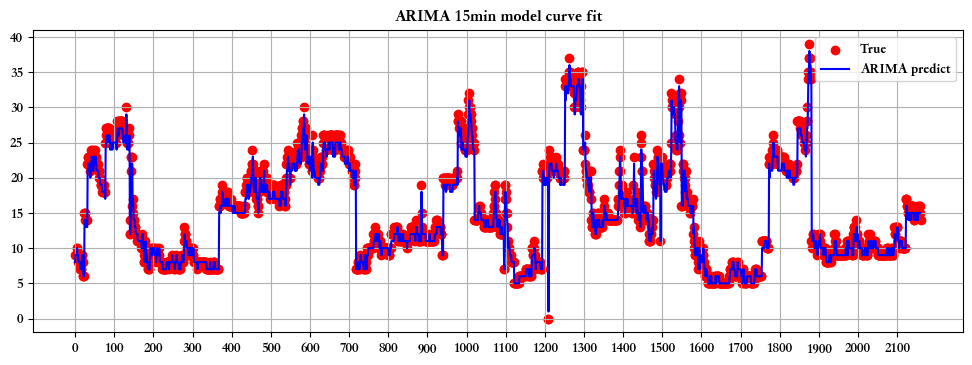

In [37]:
# 拟合情况
indexs1 = range(len(indexs1))
plt.figure(figsize = (12,4), dpi=100)
plt.scatter(indexs1, test_arima, marker='o', label='True', c='red')
plt.plot(indexs1[:-1], predictions, c='blue', label='ARIMA predict')
plt.legend()
plt.title("ARIMA 15min model curve fit")
plt.grid()
plt.xticks(np.arange(0, len(indexs1), 100))

plt.show() # 可见拟合得很好

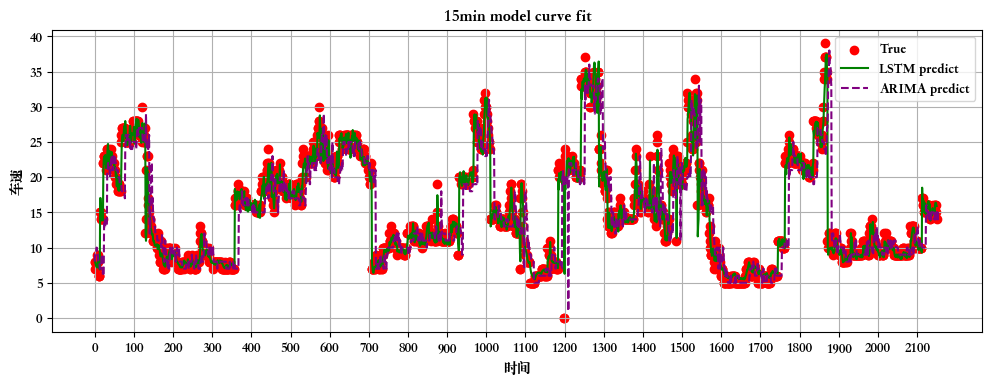

In [38]:
# 两个模型的拟合--在一张图上
# 拟合情况
plt.figure(figsize = (12,4), dpi=100)
plt.scatter(indexs, inverse_test, marker='o', label='True', c='red')
plt.plot(indexs, inverse_lstm_pred, c='green', label='LSTM predict')
plt.plot(indexs1[:-1], predictions, c='purple', label='ARIMA predict',
        linestyle='--')

plt.legend()
plt.title("15min model curve fit")
plt.xlabel("时间")
plt.ylabel("车速")
plt.grid()
plt.xticks(np.arange(0, len(indexs), 100))
plt.show() # 可见拟合得很好

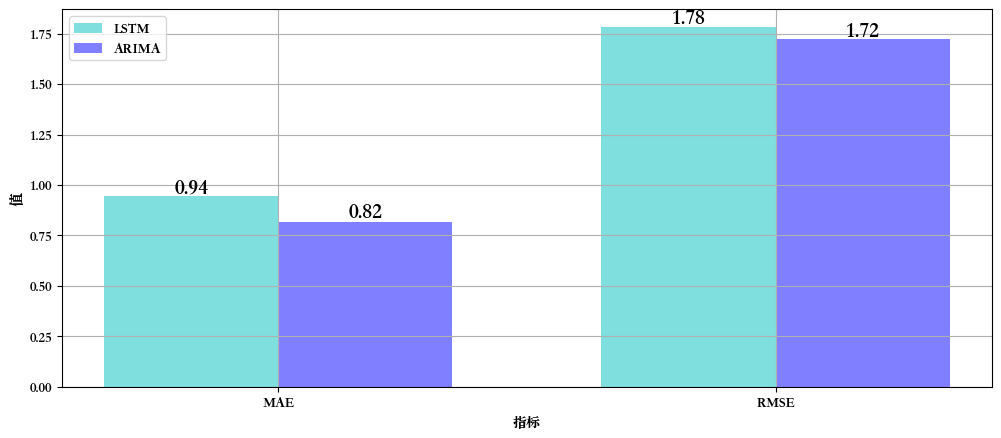

In [39]:
# 指标比较
plt.figure(figsize=(12,5),dpi=100)
xlabel = ['MAE','RMSE']
x=np.arange(len(xlabel))

y = [lstm_mae, lstm_rmse]
y1 = [arima_mae, arima_rmse]
bar_width = 0.35
rect1=plt.bar(x, y, bar_width, align="center", color="c", label="LSTM", alpha=0.5)
rect2=plt.bar(x+bar_width, y1, bar_width, color="b", align="center", label="ARIMA", alpha=0.5)
plt.xlabel("指标")
plt.ylabel("值")
plt.xticks(x+bar_width/2, xlabel)

for rect in rect1:  #rects 是三根柱子的集合
    height = round(rect.get_height(),2)
    plt.text(rect.get_x() + rect.get_width() / 2, height, str(height), size=15, ha='center', va='bottom')
for rect in rect2:  #rects 是三根柱子的集合
    height = round(rect.get_height(),2)
    plt.text(rect.get_x() + rect.get_width() / 2, height, str(height), size=15, ha='center', va='bottom')
plt.legend()
plt.grid()
plt.show()